In [ ]:
import IPython.display
import librosa
import librosa.display
import pandas as pd
import os
import struct
import json
import glob
import soundfile as sf
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
from datetime import datetime
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
#DATASET USED
#https://www.kaggle.com/datasets/sanzidaakterarusha/scream-dataset?datasetId=1903423&sortBy=dateRun&tab=collaboration

# Se obtienen las diferentes rutas de los datos, tanto audios como metadata y path para obtener las muestras
file_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/UrbanSounds8k/UrbanSound8K/audio'
screams_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/sounds-screams/good'
urbansound8k = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/UrbanSounds8k/UrbanSound8K/metadata/UrbanSound8K.csv')
file_viz = glob.glob('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/UrbanSounds8k/UrbanSound8K/audio/fold1/*')

In [ ]:
#pd.set_option('display.max_rows', None)
urbansound8k.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [ ]:
#Se organiza dataset para seleccionar la clase gun shot de interes y las otras renombrarse como no scream
urbansound8k.loc[urbansound8k["class"] != " ", "class"] = "non_scream"

In [ ]:
#Se cambian los valores de la columna classID para identificar unicamente las dos clases de interes
urbansound8k.loc[urbansound8k["classID"] != 10, "classID"] = 1
#urbansound8k.loc[urbansound8k["classID"] == 6, "classID"] = 0

In [ ]:
urbansound8k.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,1,non_scream
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,1,non_scream
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,1,non_scream
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,1,non_scream
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,1,non_scream


In [ ]:
#se cuenta el numero total de muestras de la clase de interes 
totalSamples = 0
lastNameFilesScreams=[]
for file in os.listdir(screams_path):
    if file.endswith('.wav'):
        lastNameFilesScreams.append(file)
        totalSamples+=1
print(totalSamples)

391


In [ ]:
#se toman las muestras aleatorias del tamaño de las muestras de la clase de interes para que quede balanceado
urbansound8k[urbansound8k['class'] == "non_scream"].sample(n=totalSamples).head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
6770,54898-8-0-2.wav,54898,47.992301,51.992301,2,3,1,non_scream
3534,172338-9-0-7.wav,172338,91.760480,95.760480,1,4,1,non_scream
8556,95562-4-3-0.wav,95562,8.795241,12.795241,1,3,1,non_scream
7870,75490-8-0-2.wav,75490,1.000000,5.000000,1,6,1,non_scream
1226,128891-3-0-4.wav,128891,2.000000,6.000000,1,6,1,non_scream


In [ ]:
#se toman una las muestras aleatorias del tamaño de las muestras de la clase de interes para que quede balanceado 
dfNonScream = urbansound8k[urbansound8k['class'] == "non_scream"].sample(n=totalSamples)

In [ ]:
#Se crea dataframe con los datos de los audios de sonidos de interes 
dfScream = pd.DataFrame(lastNameFilesScreams, columns=['slice_file_name'])
dfScream['classID'] = 0
dfScream['class'] = 'scream'
dfScream['fold'] = 0

In [ ]:
dfScream

,slice_file_name,classID,class,fold
0,0_scream.wav,0,scream,0
1,1_scream.wav,0,scream,0
2,3_scream.wav,0,scream,0
3,2_scream.wav,0,scream,0
4,4_scream.wav,0,scream,0
...,...,...,...,...
386,387_scream.wav,0,scream,0
387,386_scream.wav,0,scream,0
388,388_scream.wav,0,scream,0
389,390_scream.wav,0,scream,0


In [ ]:
#dfScream = urbansound8k[urbansound8k['class'] == "gun_shot"]

In [ ]:
#se unen en un solo dataset las clases de interes con muestras balanceadas
dfComplete = dfNonScream.append(dfScream)
dfComplete.count()[0]

782

In [ ]:
dfComplete[dfComplete['class'] == "scream"].count()[0]

391

In [ ]:
#Se cambia el dataset para unicamente tomar las clases de interés para el trabajo
dfComplete.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
2852,161129-4-0-11.wav,161129.0,13.775687,17.775687,1.0,8,1,non_scream
6135,34056-2-0-2.wav,34056.0,1.000000,5.000000,2.0,4,1,non_scream
1023,123685-5-0-8.wav,123685.0,7.845506,11.845506,1.0,7,1,non_scream
2481,157867-8-0-10.wav,157867.0,5.000000,9.000000,1.0,1,1,non_scream
1967,14772-7-9-0.wav,14772.0,31.891222,35.786547,1.0,7,1,non_scream


In [ ]:
class_map = {'0' : 'air_conditioner', '1' : 'car_horn', '2' : 'children_playing', '3' : 'dog_bark', '4' : 'drilling', 
                 '5' : 'engine_idling', '6' : 'gun_shot', '7' : 'jackhammer', '8' : 'siren', '9' : 'street_music'}
#Se crea el mapa de las clases a utilizar
class_map = {'8' : 'non_scream'}
pd.DataFrame(sorted(list(class_map.items())))

,0,1
0,8,non_scream


In [ ]:
#Se toman muestras del dataset para ser previsualizadas de la clase de NO interes
samples = [(class_map[label], [f for f in file_viz if f.split('-')[1] == label][0]) 
           for label in class_map.keys()]

In [ ]:
#Se toma muestra del dataset para ser previsualizadas de la clase de interes
samples.append(('scream',
  '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/sounds-screams/good/38_scream.wav'))
samples

[('non_scream',
  '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/UrbanSounds8k/UrbanSound8K/audio/fold1/106905-8-0-0.wav'),
 ('scream',
  '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/sounds-screams/good/38_scream.wav')]

In [ ]:
#Funcion para obtener los datos del sonido muestreados a una tasa de 22050 por defecto.
def get_sound_data(path, sr=22050):
    data, fsr = sf.read(path)
    data_22k = librosa.resample(data.T, fsr, sr)
    if len(data_22k.shape) > 1:
        data_22k = np.average(data_22k, axis=0)
    return data_22k, sr
sample_data = [(sample[0], get_sound_data(sample[1])) for sample in samples]
[(sample[0], sample[1][0].shape) for sample in sample_data]

[('non_scream', (88200,)), ('scream', (22528,))]

In [ ]:
#Se despliegan las muestras de los datos para ser reproducidas.
for data in sample_data:
    print(data[0], ':')
    IPython.display.display(IPython.display.Audio(data=data[1][0], rate=data[1][1]))

non_scream :


scream :


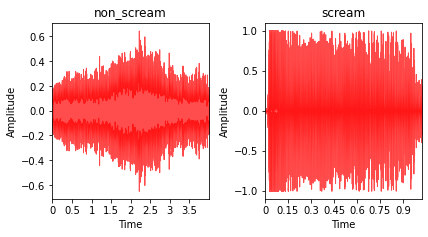

In [ ]:
#Se despliega la forma de onda para las muestras tomadas
i = 1
fig = plt.figure(figsize=(15, 6))
for item in sample_data:
    plt.subplot(2, 5, i)
    librosa.display.waveplot(item[1][0], sr=item[1][1], color='r', alpha=0.7)
    plt.title(item[0])
    plt.ylabel("Amplitude")
    i += 1
plt.tight_layout()

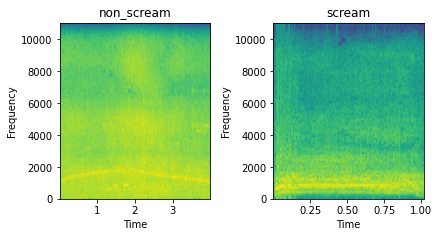

In [ ]:
#Se muestran los espectogramas correspondeintes a las muestras tomadas.
i = 1
fig = plt.figure(figsize=(15, 6))
for item in sample_data:
    plt.subplot(2, 5, i)
    specgram(item[1][0], Fs=item[1][1])
    plt.title(item[0])
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    i += 1
plt.tight_layout()

Extracting features using Librosa

In [ ]:
#Se define funcion para extrar las caracteristicas con la librería librosa, obetiendo los coeficientes ceptrales de frecuencia de Mel
#Se realiza un pading en el tamaño para que concuerden los tamaños de las caracteristicas de entrada al modelo.(?)
def extract_features(file_name, Nmfcc, Nfft, NhopL, NwinL):
    
    samplerate = 22050
    longitudMaxAudio = 4
    max_pad_len = int(samplerate*longitudMaxAudio/NhopL) + int(samplerate*longitudMaxAudio/NhopL*0.05)  #Calculo longitud de salida de mfcc con 5% de tolerancia para longitud de audios

    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=Nmfcc, n_fft=Nfft, hop_length=NhopL, win_length=NwinL)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
    #print(mfccs.shape)
    return mfccs

In [ ]:
#Se realiza la extracción de caracteristicas, teniendo en cuenta la clase, si el sonido es de la carpeta agregada de la clase explosions va y busca este sonido en la carpeta requerida

def get_features(Nmfcc, Nfft, NhopL, NwinL):
  features = []
  # Iterate through each sound file and extract the features 
  for index, row in dfComplete.iterrows():
      if(row["class"]=="non_scream"):
          file_name = os.path.join(os.path.abspath(file_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
          #file_name = ""
      elif(row["class"]=="scream"):
          file_name = os.path.join(os.path.abspath(screams_path),str(row["slice_file_name"]))
          #file_name = ""
      #print(file_name)
      class_label = row["classID"]
      data = extract_features(file_name, Nmfcc, Nfft, NhopL, NwinL)
      
      features.append([data, class_label])

  # Convert into a Panda dataframe 
  featuresdf = pd.DataFrame(features, columns=['feature','class_label'])
  return featuresdf

In [ ]:
def splitFeaturesTrainTest(featuresdf, num_rows, num_columns, num_channels):
  X = np.array(featuresdf.feature.tolist())
  y = np.array(featuresdf.class_label.tolist())

  # Encode the classification labels
  le = LabelEncoder()
  yy = to_categorical(le.fit_transform(y)) 

  # split the dataset 
  from sklearn.model_selection import train_test_split 

  x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 3)

  x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
  x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)
  num_labels = yy.shape[1]
  return x_train, x_test, y_train, y_test, num_labels

#Creating the Model

In [ ]:
# Constructing model with RELu and SoftMax activation functions:

def getModel(num_rows, num_columns, num_channels, num_labels, k_size):
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=k_size, input_shape=(num_rows, num_columns, num_channels), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=32, kernel_size=k_size, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, kernel_size=k_size, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=128, kernel_size=k_size, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(num_labels, activation='softmax'))
    return model

#DSE SCREAM

In [ ]:
specGPU = !nvidia-smi -L
specCPU = !lscpu |grep 'Model name'
specCore = !lscpu | grep 'Core(s) per socket:'

In [ ]:
print(specGPU[0])
print(specCPU[0])
print(specCore[0])

GPU 0: Tesla T4 (UUID: GPU-03e842e7-d432-d1b9-f60c-bc80deabab9d)
Model name:                      Intel(R) Xeon(R) CPU @ 2.20GHz
Core(s) per socket:              1


In [ ]:

#Model and History container
models = []
histories = []
reports = []
cmatrixs = []
trainAcc = []
testAcc = []
trainTimes = []
numberEpochsRan = []

samplerate = 22050
longitudMaxAudio = 4
valuesNmfcc = [45] #[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45]    #Valores de parametro a variar para el numero de coeficientes MFCC
valuesNfft = [256, 512, 1024, 2048, 4096]    #[256, 512, 1024, 2048, 4096]   #Valores de parametro a variar para la longitud de la FFT
valuesWinL = [256, 512, 1024, 2048, 4096]        #[256, 512, 1024, 2048, 4096] #Valores de parametro a variar para el tamaño de ventana, este debe ser menor o igual a NFFT, la función hace padding con 0
valuesHopL = [0.25, 0.5, 0.75]                   #[0.25, 0.5, 0.75]   #Valores de parametro a variar para el overlaping opuesto de hop_length
valuesKernelSize = [2, 3, 5]                  #Valores de parametro de tamaño de kernel a variar dentro del modelo


for Nmfcc in valuesNmfcc:                     #Loop para variar valores del parametro n_mfcc => Numero de coeficientes MFCC
  for Nfft in valuesNfft:                         #Loop para variar valores del parametro n_fft => Tamaño del la FFT
    for iterableNwinL in valuesWinL:              #Loop para variar valores del parametro Win_Length => Longitud de la ventana de muestreo
      if iterableNwinL<=Nfft:
        NwinL = iterableNwinL
      else:
        continue
      #if (Nfft==1024 and NwinL==256):
        #continue
      for iterableNhopL in valuesHopL:            #Loop para variar valores del parametro Hop_Length => Overlaping
        #if (Nfft==1024 and NwinL==512 and iterableNhopL==0.25 ) or (Nfft==1024 and NwinL==512 and iterableNhopL==0.5):
          #continue
        NhopL = int(iterableNhopL*NwinL)
        num_rows = Nmfcc
        num_columns = int(samplerate*longitudMaxAudio/NhopL) + int(samplerate*longitudMaxAudio/NhopL*0.05)  #Calculo longitud de salida de mfcc con 5% de tolerancia para longitud de audios
        num_channels = 1
        
        print(f'N_MFCC= {Nmfcc}, Nfft= {Nfft}, NwinL= {NwinL}, NhopL= {NhopL}')

        startP = datetime.now()
        featuresdf = get_features(Nmfcc, Nfft, NhopL, NwinL)
        durationPreprocessing = datetime.now() - startP
        totalSamples = int(dfComplete.count()[0])
        durationAvgPreprocs = durationPreprocessing/totalSamples

        print('\nPreprocessing Finished For:\n\n')
        print(f'N_MFCC= {Nmfcc}, Nfft= {Nfft}, NwinL= {NwinL}, NhopL= {NhopL}')
        print('\n\nPreprocessing Duration Average Per Sample: \n\n', durationAvgPreprocs)

        x_train, x_test, y_train, y_test, num_labels = splitFeaturesTrainTest(featuresdf, num_rows, num_columns, num_channels)


        for k_size in valuesKernelSize:           #Loop para variar valores del parametro kernel size => Tamaño del kernel de capas convolucionales
          #if (Nfft==4096 and NwinL==4096 and iterableNhopL==0.25 and k_size<=2):
            #continue
          #if (Nfft==512 and NwinL==256 and iterableNhopL==0.25 and k_size<=3) or (Nfft==512 and NwinL==256 and iterableNhopL==0.5 and k_size<=3):
            #continue
          models = []
          histories = []
          reports = []
          cmatrixs = []
          trainAcc = []
          testAcc = []
          trainTimes = []
          numberEpochsRan = []
          for i in range(5):                        #Loop para promediar el experimento realizandolo 5 veces con los mismos valores de parametros
            model = getModel(num_rows, num_columns, num_channels, num_labels, k_size)
            #Se compila el modelo con la función de perdida de crosentrpía categorica 
            model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
            # Generate a print
            print('------------------------------------------------------------------------')
            print(f'Training for N_MFCC= {Nmfcc}, Nfft= {Nfft}, NwinL= {NwinL}, NhopL= {NhopL}, Ksize= {k_size}, ...')

            #Entrenamiento del modelo 
            num_epochs = 80
            num_batch_size = 256
            
            earlystopper = EarlyStopping(patience=10, verbose=0)
            checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/DSE_scream_check', 
                                          verbose=0, save_best_only=True)
            
            start = datetime.now()
            history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data = (x_test, y_test), callbacks=[earlystopper, checkpointer], verbose=0)
            duration = datetime.now() - start
            print("Training completed in time: ", duration)
            trainTimes.append(duration)

            # Evaluating the model on the training and testing set
            score = model.evaluate(x_train, y_train, verbose=0)
            print("Training Accuracy: ", score[1])
            trainAcc.append(score[1])

            score = model.evaluate(x_test, y_test, verbose=0)
            print("Testing Accuracy: ", score[1])
            testAcc.append(score[1])

            y_true = np.argmax(y_test,axis=1)
            y_pred = np.argmax(model.predict(x_test),axis=1)
            print('\nConfusion Matrix :\n\n')
            print(confusion_matrix(y_true,y_pred))
            print('\n\nClassification Report : \n\n',classification_report(y_true,y_pred))

            # Add trained model, histoy, and reports to container
            numberEpochsRan.append(len(history.history['loss']))
            models.append(model)
            histories.append(history)
            reports.append(classification_report(y_true,y_pred))
            cmatrixs.append(confusion_matrix(y_true,y_pred))
          
          Experiment = {
            'N_MFCC': Nmfcc,
            'Nfft': Nfft,
            'NwinL': NwinL,
            'NhopL': NhopL,
            'Ksize': k_size,
            'durationAvgPreprocs': durationAvgPreprocs,
            #'models': models,
            #'histories': histories,
            'reports': reports,
            'cmatrixs': cmatrixs,
            'trainAcc': trainAcc,
            'testAcc': testAcc,
            'trainTimes': trainTimes,
            'numberEpochsRan': numberEpochsRan,
            'specGPU': specGPU[0],
            'specCPU': specCPU[0],
            'specCore': specCore[0]
          }
          
          print(Experiment)
          json_object = json.dumps(Experiment, ensure_ascii = False, indent=2, sort_keys=True, default=str)
          print(json_object)

          filenameOutput = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/DSE_scream.json"

          # 1. Read json file
          with open(filenameOutput, "r") as f:
              data = json.load(f)
              f.close() 
          # 2. Update json object
          data["Experiments"].append(Experiment)
          # 3. Write json file
          with open(filenameOutput, "w") as f:
              json.dump(data, f, ensure_ascii = False, indent=2, sort_keys=True, default=str)
              f.close()


N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 2048

Preprocessing Finished For:


N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 2048


Preprocessing Duration Average Per Sample: 

 0:00:00.860319
------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 2048, Ksize= 2, ...


Training completed in time:  0:01:47.256244
Training Accuracy:  0.9760000109672546
Testing Accuracy:  0.9426751732826233
5/5 [==============================] - 0s 3ms/step

Confusion Matrix :


[[68  5]
 [ 4 80]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.94      0.93      0.94        73
           1       0.94      0.95      0.95        84

    accuracy                           0.94       157
   macro avg       0.94      0.94      0.94       157
weighted avg       0.94      0.94      0.94       157

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 2048, Ksize= 2, ...


Training completed in time:  0:01:22.522017
Training Accuracy:  0.9760000109672546
Testing Accuracy:  0.9426751732826233
5/5 [==============================] - 0s 2ms/step

Confusion Matrix :


[[69  4]
 [ 5 79]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.93      0.95      0.94        73
           1       0.95      0.94      0.95        84

    accuracy                           0.94       157
   macro avg       0.94      0.94      0.94       157
weighted avg       0.94      0.94      0.94       157

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 2048, Ksize= 2, ...


Training completed in time:  0:00:37.209548
Training Accuracy:  0.9007999897003174
Testing Accuracy:  0.9108280539512634
5/5 [==============================] - 0s 3ms/step

Confusion Matrix :


[[66  7]
 [ 7 77]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.90      0.90      0.90        73
           1       0.92      0.92      0.92        84

    accuracy                           0.91       157
   macro avg       0.91      0.91      0.91       157
weighted avg       0.91      0.91      0.91       157

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 2048, Ksize= 2, ...


Training completed in time:  0:01:06.844579
Training Accuracy:  0.9616000056266785
Testing Accuracy:  0.9426751732826233
5/5 [==============================] - 0s 3ms/step

Confusion Matrix :


[[69  4]
 [ 5 79]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.93      0.95      0.94        73
           1       0.95      0.94      0.95        84

    accuracy                           0.94       157
   macro avg       0.94      0.94      0.94       157
weighted avg       0.94      0.94      0.94       157

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 2048, Ksize= 2, ...


Training completed in time:  0:00:59.091005
Training Accuracy:  0.9503999948501587
Testing Accuracy:  0.9426751732826233
5/5 [==============================] - 0s 3ms/step

Confusion Matrix :


[[67  6]
 [ 3 81]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.96      0.92      0.94        73
           1       0.93      0.96      0.95        84

    accuracy                           0.94       157
   macro avg       0.94      0.94      0.94       157
weighted avg       0.94      0.94      0.94       157

{'N_MFCC': 45, 'Nfft': 4096, 'NwinL': 4096, 'NhopL': 2048, 'Ksize': 2, 'durationAvgPreprocs': datetime.timedelta(microseconds=860319), 'reports': ['              precision    recall  f1-score   support\n\n           0       0.94      0.93      0.94        73\n           1       0.94      0.95      0.95        84\n\n    accuracy                           0.94       157\n   macro avg       0.94      0.94      0.94       157\nweig

Training completed in time:  0:01:21.397834
Training Accuracy:  0.9887999892234802
Testing Accuracy:  0.987261176109314
5/5 [==============================] - 0s 3ms/step

Confusion Matrix :


[[71  2]
 [ 0 84]]


Classification Report : 

               precision    recall  f1-score   support

           0       1.00      0.97      0.99        73
           1       0.98      1.00      0.99        84

    accuracy                           0.99       157
   macro avg       0.99      0.99      0.99       157
weighted avg       0.99      0.99      0.99       157

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 2048, Ksize= 3, ...


Training completed in time:  0:01:21.187994
Training Accuracy:  0.995199978351593
Testing Accuracy:  0.9554139971733093
5/5 [==============================] - 0s 3ms/step

Confusion Matrix :


[[71  2]
 [ 5 79]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.93      0.97      0.95        73
           1       0.98      0.94      0.96        84

    accuracy                           0.96       157
   macro avg       0.95      0.96      0.96       157
weighted avg       0.96      0.96      0.96       157

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 2048, Ksize= 3, ...


Training completed in time:  0:01:19.434211
Training Accuracy:  0.9936000108718872
Testing Accuracy:  0.9554139971733093
5/5 [==============================] - 0s 3ms/step

Confusion Matrix :


[[71  2]
 [ 5 79]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.93      0.97      0.95        73
           1       0.98      0.94      0.96        84

    accuracy                           0.96       157
   macro avg       0.95      0.96      0.96       157
weighted avg       0.96      0.96      0.96       157

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 2048, Ksize= 3, ...


Training completed in time:  0:01:26.701394
Training Accuracy:  0.9919999837875366
Testing Accuracy:  0.9554139971733093
5/5 [==============================] - 0s 3ms/step

Confusion Matrix :


[[71  2]
 [ 5 79]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.93      0.97      0.95        73
           1       0.98      0.94      0.96        84

    accuracy                           0.96       157
   macro avg       0.95      0.96      0.96       157
weighted avg       0.96      0.96      0.96       157

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 2048, Ksize= 3, ...


Training completed in time:  0:01:10.402809
Training Accuracy:  0.9855999946594238
Testing Accuracy:  0.9490445852279663
5/5 [==============================] - 0s 4ms/step

Confusion Matrix :


[[71  2]
 [ 6 78]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.92      0.97      0.95        73
           1       0.97      0.93      0.95        84

    accuracy                           0.95       157
   macro avg       0.95      0.95      0.95       157
weighted avg       0.95      0.95      0.95       157

{'N_MFCC': 45, 'Nfft': 4096, 'NwinL': 4096, 'NhopL': 2048, 'Ksize': 3, 'durationAvgPreprocs': datetime.timedelta(microseconds=860319), 'reports': ['              precision    recall  f1-score   support\n\n           0       1.00      0.97      0.99        73\n           1       0.98      1.00      0.99        84\n\n    accuracy                           0.99       157\n   macro avg       0.99      0.99      0.99       157\nweig

Training completed in time:  0:00:58.970541
Training Accuracy:  0.995199978351593
Testing Accuracy:  0.9745222926139832
5/5 [==============================] - 0s 3ms/step

Confusion Matrix :


[[72  1]
 [ 3 81]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.96      0.99      0.97        73
           1       0.99      0.96      0.98        84

    accuracy                           0.97       157
   macro avg       0.97      0.98      0.97       157
weighted avg       0.97      0.97      0.97       157

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 2048, Ksize= 5, ...


Training completed in time:  0:01:04.390107
Training Accuracy:  0.9936000108718872
Testing Accuracy:  0.9808917045593262
5/5 [==============================] - 0s 3ms/step

Confusion Matrix :


[[72  1]
 [ 2 82]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.97      0.99      0.98        73
           1       0.99      0.98      0.98        84

    accuracy                           0.98       157
   macro avg       0.98      0.98      0.98       157
weighted avg       0.98      0.98      0.98       157

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 2048, Ksize= 5, ...


Training completed in time:  0:01:17.500346
Training Accuracy:  0.995199978351593
Testing Accuracy:  0.9745222926139832
5/5 [==============================] - 0s 4ms/step

Confusion Matrix :


[[71  2]
 [ 2 82]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.97      0.97      0.97        73
           1       0.98      0.98      0.98        84

    accuracy                           0.97       157
   macro avg       0.97      0.97      0.97       157
weighted avg       0.97      0.97      0.97       157

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 2048, Ksize= 5, ...


Training completed in time:  0:00:49.225869
Training Accuracy:  0.995199978351593
Testing Accuracy:  0.9681528806686401
5/5 [==============================] - 0s 3ms/step

Confusion Matrix :


[[71  2]
 [ 3 81]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.96      0.97      0.97        73
           1       0.98      0.96      0.97        84

    accuracy                           0.97       157
   macro avg       0.97      0.97      0.97       157
weighted avg       0.97      0.97      0.97       157

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 2048, Ksize= 5, ...


Training completed in time:  0:01:03.549556
Training Accuracy:  0.9872000217437744
Testing Accuracy:  0.9617834687232971
5/5 [==============================] - 0s 3ms/step

Confusion Matrix :


[[72  1]
 [ 5 79]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.94      0.99      0.96        73
           1       0.99      0.94      0.96        84

    accuracy                           0.96       157
   macro avg       0.96      0.96      0.96       157
weighted avg       0.96      0.96      0.96       157

{'N_MFCC': 45, 'Nfft': 4096, 'NwinL': 4096, 'NhopL': 2048, 'Ksize': 5, 'durationAvgPreprocs': datetime.timedelta(microseconds=860319), 'reports': ['              precision    recall  f1-score   support\n\n           0       0.96      0.99      0.97        73\n           1       0.99      0.96      0.98        84\n\n    accuracy                           0.97       157\n   macro avg       0.97      0.98      0.97       157\nweig

Training completed in time:  0:01:22.554960
Training Accuracy:  0.9824000000953674
Testing Accuracy:  0.9617834687232971
5/5 [==============================] - 0s 3ms/step

Confusion Matrix :


[[71  2]
 [ 4 80]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.95      0.97      0.96        73
           1       0.98      0.95      0.96        84

    accuracy                           0.96       157
   macro avg       0.96      0.96      0.96       157
weighted avg       0.96      0.96      0.96       157

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 3072, Ksize= 2, ...


Training completed in time:  0:01:11.590728
Training Accuracy:  0.9824000000953674
Testing Accuracy:  0.9681528806686401
5/5 [==============================] - 0s 3ms/step

Confusion Matrix :


[[72  1]
 [ 4 80]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.95      0.99      0.97        73
           1       0.99      0.95      0.97        84

    accuracy                           0.97       157
   macro avg       0.97      0.97      0.97       157
weighted avg       0.97      0.97      0.97       157

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 3072, Ksize= 2, ...


Training completed in time:  0:01:13.299143
Training Accuracy:  0.979200005531311
Testing Accuracy:  0.9490445852279663
5/5 [==============================] - 0s 3ms/step

Confusion Matrix :


[[71  2]
 [ 6 78]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.92      0.97      0.95        73
           1       0.97      0.93      0.95        84

    accuracy                           0.95       157
   macro avg       0.95      0.95      0.95       157
weighted avg       0.95      0.95      0.95       157

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 3072, Ksize= 2, ...


Training completed in time:  0:01:13.088867
Training Accuracy:  0.9872000217437744
Testing Accuracy:  0.9617834687232971
5/5 [==============================] - 0s 3ms/step

Confusion Matrix :


[[72  1]
 [ 5 79]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.94      0.99      0.96        73
           1       0.99      0.94      0.96        84

    accuracy                           0.96       157
   macro avg       0.96      0.96      0.96       157
weighted avg       0.96      0.96      0.96       157

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 3072, Ksize= 2, ...


Training completed in time:  0:00:58.593095
Training Accuracy:  0.974399983882904
Testing Accuracy:  0.9426751732826233
5/5 [==============================] - 0s 3ms/step

Confusion Matrix :


[[69  4]
 [ 5 79]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.93      0.95      0.94        73
           1       0.95      0.94      0.95        84

    accuracy                           0.94       157
   macro avg       0.94      0.94      0.94       157
weighted avg       0.94      0.94      0.94       157

{'N_MFCC': 45, 'Nfft': 4096, 'NwinL': 4096, 'NhopL': 3072, 'Ksize': 2, 'durationAvgPreprocs': datetime.timedelta(microseconds=44775), 'reports': ['              precision    recall  f1-score   support\n\n           0       0.95      0.97      0.96        73\n           1       0.98      0.95      0.96        84\n\n    accuracy                           0.96       157\n   macro avg       0.96      0.96      0.96       157\nweight

Training completed in time:  0:02:22.955167
Training Accuracy:  0.9919999837875366
Testing Accuracy:  0.9490445852279663
5/5 [==============================] - 0s 3ms/step

Confusion Matrix :


[[70  3]
 [ 5 79]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.93      0.96      0.95        73
           1       0.96      0.94      0.95        84

    accuracy                           0.95       157
   macro avg       0.95      0.95      0.95       157
weighted avg       0.95      0.95      0.95       157

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 3072, Ksize= 3, ...


Training completed in time:  0:00:05.025261
Training Accuracy:  0.758400022983551
Testing Accuracy:  0.7834395170211792
5/5 [==============================] - 0s 3ms/step

Confusion Matrix :


[[65  8]
 [26 58]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.71      0.89      0.79        73
           1       0.88      0.69      0.77        84

    accuracy                           0.78       157
   macro avg       0.80      0.79      0.78       157
weighted avg       0.80      0.78      0.78       157

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 3072, Ksize= 3, ...


Training completed in time:  0:01:10.947599
Training Accuracy:  0.9855999946594238
Testing Accuracy:  0.9554139971733093
5/5 [==============================] - 0s 5ms/step

Confusion Matrix :


[[71  2]
 [ 5 79]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.93      0.97      0.95        73
           1       0.98      0.94      0.96        84

    accuracy                           0.96       157
   macro avg       0.95      0.96      0.96       157
weighted avg       0.96      0.96      0.96       157

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 3072, Ksize= 3, ...


Training completed in time:  0:01:27.734973
Training Accuracy:  0.9919999837875366
Testing Accuracy:  0.9681528806686401
5/5 [==============================] - 0s 5ms/step

Confusion Matrix :


[[71  2]
 [ 3 81]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.96      0.97      0.97        73
           1       0.98      0.96      0.97        84

    accuracy                           0.97       157
   macro avg       0.97      0.97      0.97       157
weighted avg       0.97      0.97      0.97       157

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 3072, Ksize= 3, ...


Training completed in time:  0:01:22.776079
Training Accuracy:  0.995199978351593
Testing Accuracy:  0.9808917045593262
5/5 [==============================] - 0s 3ms/step

Confusion Matrix :


[[71  2]
 [ 1 83]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.99      0.97      0.98        73
           1       0.98      0.99      0.98        84

    accuracy                           0.98       157
   macro avg       0.98      0.98      0.98       157
weighted avg       0.98      0.98      0.98       157

{'N_MFCC': 45, 'Nfft': 4096, 'NwinL': 4096, 'NhopL': 3072, 'Ksize': 3, 'durationAvgPreprocs': datetime.timedelta(microseconds=44775), 'reports': ['              precision    recall  f1-score   support\n\n           0       0.93      0.96      0.95        73\n           1       0.96      0.94      0.95        84\n\n    accuracy                           0.95       157\n   macro avg       0.95      0.95      0.95       157\nweight

Training completed in time:  0:01:22.505587
Training Accuracy:  1.0
Testing Accuracy:  0.987261176109314
5/5 [==============================] - 0s 4ms/step

Confusion Matrix :


[[71  2]
 [ 0 84]]


Classification Report : 

               precision    recall  f1-score   support

           0       1.00      0.97      0.99        73
           1       0.98      1.00      0.99        84

    accuracy                           0.99       157
   macro avg       0.99      0.99      0.99       157
weighted avg       0.99      0.99      0.99       157

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 3072, Ksize= 5, ...


Training completed in time:  0:01:22.513149
Training Accuracy:  0.9919999837875366
Testing Accuracy:  0.9426751732826233
5/5 [==============================] - 0s 4ms/step

Confusion Matrix :


[[70  3]
 [ 6 78]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.92      0.96      0.94        73
           1       0.96      0.93      0.95        84

    accuracy                           0.94       157
   macro avg       0.94      0.94      0.94       157
weighted avg       0.94      0.94      0.94       157

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 3072, Ksize= 5, ...


Training completed in time:  0:01:11.523148
Training Accuracy:  0.9904000163078308
Testing Accuracy:  0.9554139971733093
5/5 [==============================] - 0s 4ms/step

Confusion Matrix :


[[71  2]
 [ 5 79]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.93      0.97      0.95        73
           1       0.98      0.94      0.96        84

    accuracy                           0.96       157
   macro avg       0.95      0.96      0.96       157
weighted avg       0.96      0.96      0.96       157

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 3072, Ksize= 5, ...


Training completed in time:  0:01:08.666350
Training Accuracy:  0.995199978351593
Testing Accuracy:  0.9745222926139832
5/5 [==============================] - 0s 3ms/step

Confusion Matrix :


[[71  2]
 [ 2 82]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.97      0.97      0.97        73
           1       0.98      0.98      0.98        84

    accuracy                           0.97       157
   macro avg       0.97      0.97      0.97       157
weighted avg       0.97      0.97      0.97       157

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 3072, Ksize= 5, ...


Training completed in time:  0:01:06.850446
Training Accuracy:  1.0
Testing Accuracy:  0.9745222926139832
5/5 [==============================] - 0s 3ms/step

Confusion Matrix :


[[70  3]
 [ 1 83]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.99      0.96      0.97        73
           1       0.97      0.99      0.98        84

    accuracy                           0.97       157
   macro avg       0.98      0.97      0.97       157
weighted avg       0.97      0.97      0.97       157

{'N_MFCC': 45, 'Nfft': 4096, 'NwinL': 4096, 'NhopL': 3072, 'Ksize': 5, 'durationAvgPreprocs': datetime.timedelta(microseconds=44775), 'reports': ['              precision    recall  f1-score   support\n\n           0       1.00      0.97      0.99        73\n           1       0.98      1.00      0.99        84\n\n    accuracy                           0.99       157\n   macro avg       0.99      0.99      0.99       157\nweighted avg       0

#Evaluation Metrics

In [ ]:
f1Scores = []
mfccNumbers = []
accuracys = []

N_MFCC = 1
for i in range(len(reports)):
  print(f'\n\nN_MFCC {N_MFCC}')
  print(f'Classification Report {i}: \n\n', reports[i])
  mfccNumbers.append(N_MFCC)
  f1Scores.append(float(reports[i].split()[7]))
  accuracys.append(float(reports[i].split()[15]))
  N_MFCC += 2



N_MFCC 1
Classification Report 0: 

               precision    recall  f1-score   support

           0       0.82      0.84      0.83        73
           1       0.86      0.85      0.85        84

    accuracy                           0.84       157
   macro avg       0.84      0.84      0.84       157
weighted avg       0.84      0.84      0.84       157



N_MFCC 3
Classification Report 1: 

               precision    recall  f1-score   support

           0       0.84      0.99      0.91        73
           1       0.99      0.83      0.90        84

    accuracy                           0.90       157
   macro avg       0.91      0.91      0.90       157
weighted avg       0.92      0.90      0.90       157



N_MFCC 5
Classification Report 2: 

               precision    recall  f1-score   support

           0       0.85      0.86      0.86        73
           1       0.88      0.87      0.87        84

    accuracy                           0.87       157
   macro av

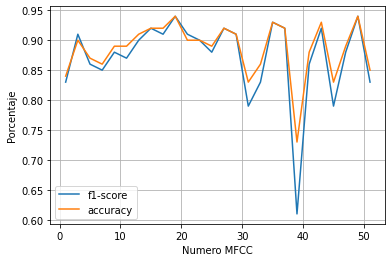

In [ ]:
# Plotting Accuracy and F1-Score of Models

plt.plot(mfccNumbers,f1Scores,  label='f1-score')
plt.plot(mfccNumbers,accuracys, label='accuracy', )
plt.xlabel('Numero MFCC')
plt.ylabel('Porcentaje')
plt.legend()
plt.grid(True)

In [ ]:
f1Scores = []
mfccNumbers = []
accuracys = []

N_MFCC = 1
for i in range(len(reports)):
  print(f'\n\nN_MFCC {N_MFCC}')
  print(f'Classification Report {i}: \n\n', reports[i])
  mfccNumbers.append(N_MFCC)
  f1Scores.append(float(reports[i].split()[7])*100)
  accuracys.append(float(reports[i].split()[15])*100)
  N_MFCC += 2

In [ ]:
# Plotting Accuracy and F1-Score of Models

plt.plot(mfccNumbers,f1Scores,  label='f1-score')
plt.plot(mfccNumbers,accuracys, label='accuracy', )
plt.xlabel('Numero MFCC')
plt.ylabel('Porcentaje')
plt.legend()
plt.grid(True)

#Save the entire model as a SavedModel.

In [ ]:
#!mkdir -p saved_model

model.save('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/scream/saved_scream')

#Reload a fresh Keras model from the saved model

In [ ]:
import IPython.display
import librosa
import librosa.display
import pandas as pd
import os
import struct
import glob
import soundfile as sf
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint 
from datetime import datetime
from sklearn import metrics 
import librosa as lb
import IPython.display as ipd
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
def predict(path):
    num_rows = 40
    num_columns = 174
    num_channels = 1
    audio = extract_features(path)
    audioP = audio.reshape(1, num_rows, num_columns, num_channels)
    probOut = model.predict(audioP)[0]
    indexMax = np.argmax(probOut)
    print(probOut)
    print(indexMax)
    maxProb = probOut[indexMax]
    if(maxProb>0.70):
      if(indexMax==0):
        classP = 'scream'
      else:
        classP = 'non_scream'
    else:
      classP = 'None'
    print('Class predicted :',classP,'\n\n')
    return ipd.Audio(path)

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/scream/saved_scream')

# Check its architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 39, 173, 16)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 86, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 19, 86, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 85, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 42, 32)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 9, 42, 32)         0

In [ ]:
predict('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/UrbanSounds8k/UrbanSound8K/audio/fold7/102853-8-0-1.wav')


1/1 [==============================] - 0s 124ms/step
[0.11822042 0.88177955]
1
Class predicted : non_scream 




In [ ]:
predict('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/sounds-screams/good/38_scream.wav')

1/1 [==============================] - 0s 40ms/step
[0.752234   0.24776606]
0
Class predicted : scream 




#To record and save audio directly on colab

In [ ]:
#Se implementan funciones para grabar y guardar audio directamente desde el colab
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
!pip -q install pydub
from pydub import AudioSegment

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1200))
  b = b64decode(s.split(',')[1])
  audio = AudioSegment.from_file(BytesIO(b))
  return audio

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def recordAndSave(sec=3, path="audio.wav"):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1200))
  b = b64decode(s.split(',')[1])
  with open(path,'wb') as f:
    f.write(b)
  return path  # or webm ?

In [ ]:
#Grabar porción de audio directamente desde el colab
pathaudio2 = recordAndSave(sec=3,path='/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/sonidosPrueba/prueba1.wav')

<IPython.core.display.Javascript object>

In [ ]:
#Se predice el audio que fue grabado anteriormente
predict(pathaudio2)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[0.9985104  0.00148962]
0
Class predicted : gun_shot 




In [ ]:
#Grabar porción de audio directamente desde el colab
pathaudio3 = recordAndSave(sec=3,path='/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/sonidosPrueba/prueba2.wav')

<IPython.core.display.Javascript object>

In [ ]:
#Se predice el audio que fue grabado anteriormente
predict(pathaudio3)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[3.7462482e-07 9.9999964e-01]
1
Class predicted : siren 


